In [1]:
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
pattern = "GATCTATA"
text = "GTCTATA"

# pattern = "TCTTTACTCGCGCGTTGGAGAAATACAATAGTTCTTTACTCGCGCGTTGGAGAAATACAATAGTTCTTTACTCGCGCGTTGGAGAAATACAATAGTTCTTTACTCGCGCGTTGGAGAAATACAATTTTTTTTTTTTTTTTT"
text = "TCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTTTTTTTTTTTTTTTTTTT"

In [4]:
compile_command = "gcc wfa_basic.c /home/jupyter-administrator/WFA2-lib/wavefront/avx_wavefront_extension_iteration.o -O3 -o wfa_basic -I.. -L../lib -lwfa -lm -g -march=skylake-avx512"
subprocess.run(compile_command, shell=True, check=True)

CompletedProcess(args='gcc wfa_basic.c /home/jupyter-administrator/WFA2-lib/wavefront/avx_wavefront_extension_iteration.o -O3 -o wfa_basic -I.. -L../lib -lwfa -lm -g -march=skylake-avx512', returncode=0)

In [5]:
program_path = './wfa_basic'
run_command = f"./wfa_basic {pattern} {text}"
result = subprocess.run(run_command, shell=True, text=True, capture_output=True, check=True)
output = result.stderr

In [6]:
heatmap_markers = ["# Heatmap M", "# Heatmap I1", "# Heatmap D1", "# Heatmap Extend"]
end_marker = "# List CIGAR-M"

In [7]:
def extract_heatmaps(output):
    heatmaps = {}
    current_heatmap_name = None
    current_heatmap_data = []

    for line in output.splitlines():
        if any(marker in line for marker in heatmap_markers):
            if current_heatmap_name and current_heatmap_data:
                heatmaps[current_heatmap_name] = np.array(current_heatmap_data)
                current_heatmap_data = []
            current_heatmap_name = line.strip().replace("# ", "")
            continue

        if end_marker in line:
            if current_heatmap_name and current_heatmap_data:
                heatmaps[current_heatmap_name] = np.array(current_heatmap_data)
            break

        if current_heatmap_name:
            row = [float(value.strip()) for value in line.split(',')]
            current_heatmap_data.append(row)

    return heatmaps

In [8]:
heatmaps = extract_heatmaps(output)

In [9]:
current_heatmap_name = None
for line in output.splitlines():
    if any(marker in line for marker in heatmap_markers):
        current_heatmap_name = line.strip().replace("# ", "")
        continue
    if end_marker in line:
        current_heatmap_name = None
        continue
    if current_heatmap_name:
        continue  
    print(line)

WFA-Alignment returns score -294
  PATTERN  GATCTATA
  TEXT     TCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTTTTTTTTTTTTTTTTTTT
  SCORE (RE)COMPUTED -294
      ALIGNMENT 30I1M1X6M109I
      ETRACE    30I1X109I
      CIGAR     30I8M109I
      PATTERN    ------------------------------GATCTATA-------------------------------------------------------------------------------------------------------------
                                               | ||||||                                                                                                             
      TEXT       TCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTTTTTTTTTTTTTTTTTTT
# PatternLength 8
# Pattern GATCTATA
# TextLength 147
# Text TCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAATAGTTCTATACTGCGCGTTTGGAGAAATAAAA

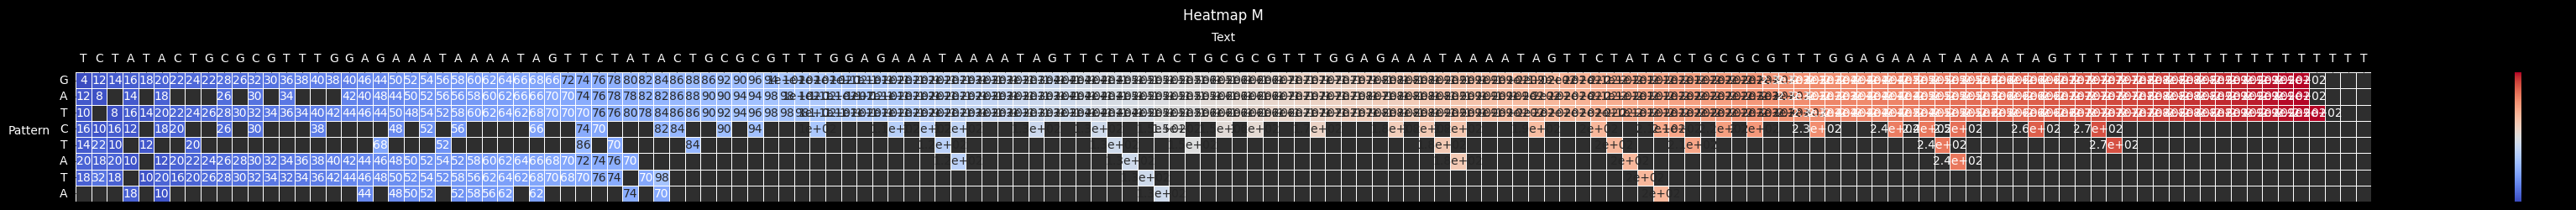

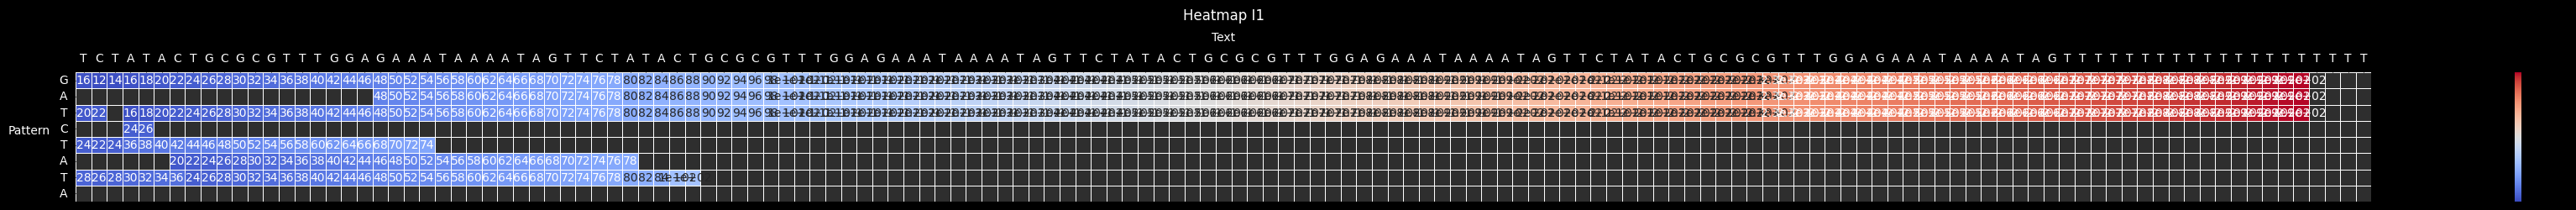

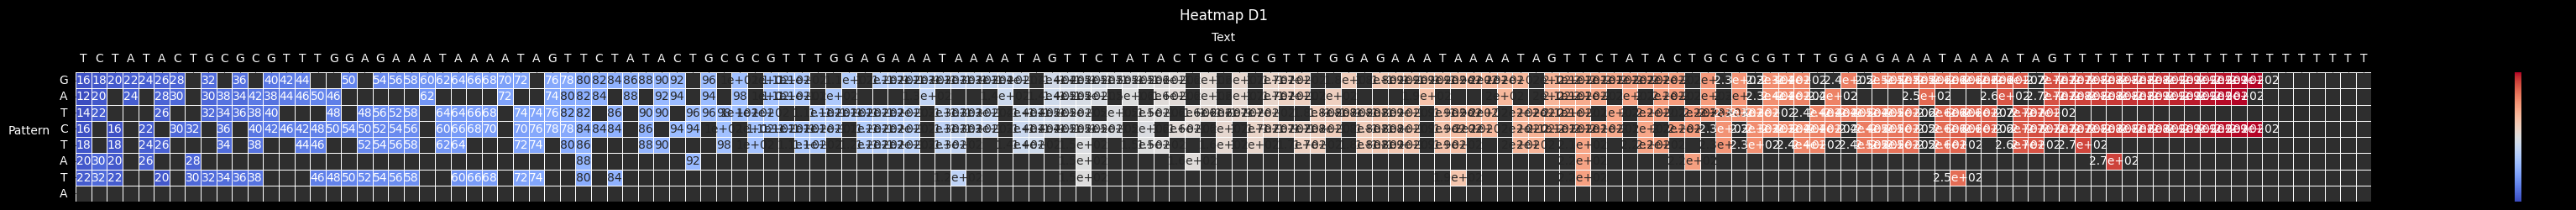

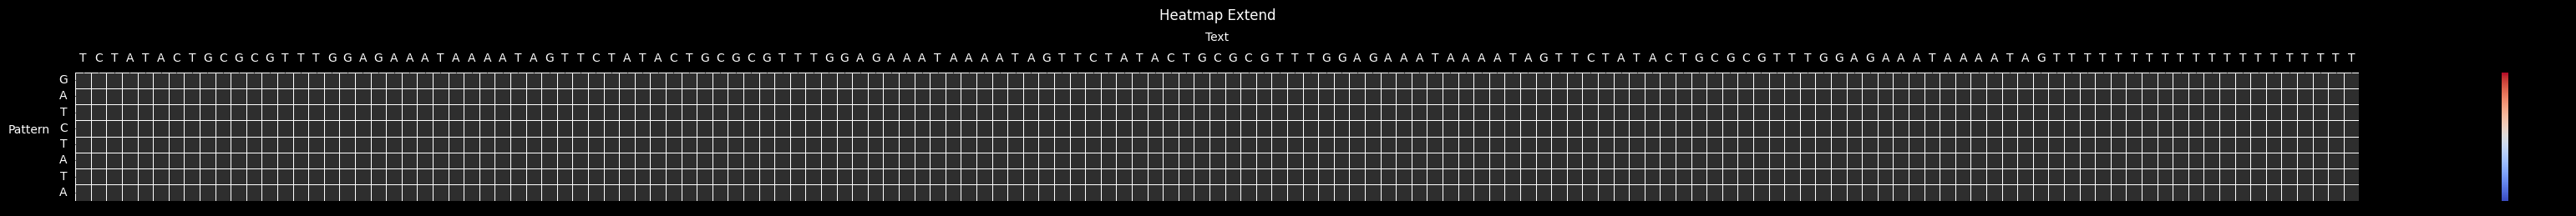

In [10]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad('#2e2e2e')

max_width = 45
max_height = 30

fig_width = min(len(text) * 0.3, max_width)
fig_height = min(len(pattern) * 0.25, max_height)

if len(pattern) <= 150 or len(text) <= 150:
    for heatmap_name, heatmap_data in heatmaps.items():
        heatmap_data = np.where(heatmap_data == -1, np.nan, heatmap_data)
        heatmap_values = np.array(heatmap_data)
        # Create the heatmap
        plt.figure(figsize=(fig_width, fig_height))
        plt.gcf().set_facecolor('black')
        
        sns.heatmap(heatmap_values, annot=True, cmap=cmap, mask=np.isnan(heatmap_data), cbar=True, linewidths=.5, cbar_kws={'label': 'Value'})
    
        plt.xlabel("Text", color="white", labelpad=10)
        plt.xticks(ticks=np.arange(0.5, len(text), 1), labels=list(text), color='white')
    
        plt.ylabel("Pattern", color="white", rotation=0, labelpad=25)
        plt.yticks(ticks=np.arange(0.5, len(pattern), 1), labels=list(pattern), color='white', rotation=0)
    
        plt.gca().xaxis.set_ticks_position('top')
        plt.gca().xaxis.set_label_position('top')
        
        # Set the title
        plt.title(heatmap_name, color='white', pad=10)
            
        # Show the plot
        plt.show()
else:
    print("Why is mine so small?!")